# Load CSVs

In [1]:
#Load Dependencies
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
import os

In [2]:
#Load CSV
# df = pd.read_csv("../mergedata_%change.csv")
df = pd.read_csv("../PRE_POST_VOL")
df.head()

,Unnamed: 0,Pre_Tweet_Vol,Post_Tweet_Vol,Vol Change,Tweet,Tweet Time
0,551,-0.010892,0.001412,0.012304,Just had a very good tele-conference with Nat...,20200316 1332
1,915,-0.008380,0.003885,0.012264,The Federal Reserve is cutting but must furthe...,20200303 1051
2,465,0.008989,0.018959,0.009970,Thank you @HerschelWalker! https://t.co/qBXOa4...,20200318 1550
3,7269,-0.007727,0.001513,0.009240,Today we honor all of our Country’s Purple Hea...,20190807 0946
4,1031,-0.005200,0.003462,0.008661,“You go around Pennsylvania and you see Trump ...,20200228 1030


In [3]:
#Load Tweet df
try:
    df_tweet_sent = pd.read_csv("../FinalProject- SR/Resources/FinalTrumpTweet3.csv")
except UnicodeDecodeError:
    pass

df_tweet_sent.shape

(16715, 7)

In [4]:
#Bin volatility movement into +1,0,-1 and establish threshold

market_movements = []
pos_threshold = 0.0003
neg_threshold = pos_threshold * -1

for index, row in df.iterrows():
    if row['Vol Change'] >= pos_threshold:
        market_movement = 1
        market_movements.append(market_movement)
    elif row['Vol Change'] <= neg_threshold:
        market_movement = -1
        market_movements.append(market_movement)
    else:
        market_movement = 0
        market_movements.append(market_movement)

#Add new list as column to df
df['Market Movement'] = market_movements
df.head()

,Unnamed: 0,Pre_Tweet_Vol,Post_Tweet_Vol,Vol Change,Tweet,Tweet Time,Market Movement
0,551,-0.010892,0.001412,0.012304,Just had a very good tele-conference with Nat...,20200316 1332,1
1,915,-0.008380,0.003885,0.012264,The Federal Reserve is cutting but must furthe...,20200303 1051,1
2,465,0.008989,0.018959,0.009970,Thank you @HerschelWalker! https://t.co/qBXOa4...,20200318 1550,1
3,7269,-0.007727,0.001513,0.009240,Today we honor all of our Country’s Purple Hea...,20190807 0946,1
4,1031,-0.005200,0.003462,0.008661,“You go around Pennsylvania and you see Trump ...,20200228 1030,1


In [5]:
from textblob import TextBlob
import re

def clean_tweet(tweet):
    '''
    Utility function to clean the text in a tweet by removing 
    links and special characters using regex.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def analize_sentiment(tweet):
    '''
    Utility function to classify the polarity of a tweet
    using textblob.
    '''
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1
    
#1 means positive, 0 means neutral, -1 means negative

In [6]:
df['SA'] = np.array([ analize_sentiment(tweet) for tweet in df['Tweet'] ])

In [7]:
df.shape

(2309, 8)

In [8]:
# tokenize, then remove stopwords, ngrams, sentiment analysis feature selection
#either truncate or append to vector
data = df.merge(df_tweet_sent, left_on='Unnamed: 0', right_on='Unnamed: 0')
data = data.drop(columns=['Pre_Tweet_Vol','Post_Tweet_Vol','source','is_retweet', 'created_at','text', 'Unnamed: 0'])
data = data.rename(columns = {'retweet_count':'Retweets','favorite_count':'Favorites'})
data.head()

,Vol Change,Tweet,Tweet Time,Market Movement,SA,Retweets,Favorites
0,0.012304,Just had a very good tele-conference with Nat...,20200316 1332,1,1,17025.0,98450.0
1,0.012264,The Federal Reserve is cutting but must furthe...,20200303 1051,1,-1,19291.0,79414.0
2,0.009970,Thank you @HerschelWalker! https://t.co/qBXOa4...,20200318 1550,1,0,12501.0,57676.0
3,0.009240,Today we honor all of our Country’s Purple Hea...,20190807 0946,1,1,14234.0,56571.0
4,0.008661,“You go around Pennsylvania and you see Trump ...,20200228 1030,1,0,14015.0,57284.0


In [9]:
data.shape

(2309, 7)

In [10]:
from datetime import datetime
data['Tweet Time'] = data['Tweet Time'].str[9:14]
data.head()

,Vol Change,Tweet,Tweet Time,Market Movement,SA,Retweets,Favorites
0,0.012304,Just had a very good tele-conference with Nat...,1332,1,1,17025.0,98450.0
1,0.012264,The Federal Reserve is cutting but must furthe...,1051,1,-1,19291.0,79414.0
2,0.009970,Thank you @HerschelWalker! https://t.co/qBXOa4...,1550,1,0,12501.0,57676.0
3,0.009240,Today we honor all of our Country’s Purple Hea...,0946,1,1,14234.0,56571.0
4,0.008661,“You go around Pennsylvania and you see Trump ...,1030,1,0,14015.0,57284.0


## Count Vectorizer

In [12]:
#Call out features
features = data.columns
features = data[['Tweet Time', 'Retweets', 'Favorites', 'SA']].copy()

#State target output, name the %change bins
target = data["Market Movement"]
target_names = ["Positive", "No Effect", "Negative"]

In [13]:
features.head()

,Tweet Time,Retweets,Favorites,SA
0,1332,17025.0,98450.0,1
1,1051,19291.0,79414.0,-1
2,1550,12501.0,57676.0,0
3,0946,14234.0,56571.0,1
4,1030,14015.0,57284.0,0


In [14]:
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import stop_words

C:\Users\Natha\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [15]:
# preprocess = make_column_transformer(
#     (MinMaxScaler(), [ 'Tweet Time', 'Retweets', 'Favorites', 'SA']))
#     (CountVectorizer(analyzer='word', stop_words = 'english', ngram_range=(1,3)), ['Tweet']))
preprocess = preprocessing.MinMaxScaler()

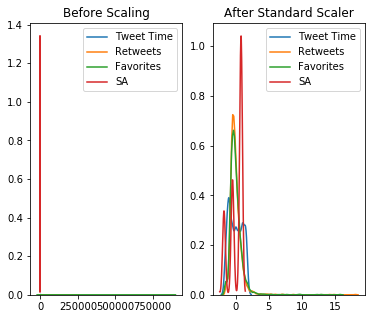

<Figure size 1008x576 with 0 Axes>

In [22]:
import seaborn as sns
%matplotlib inline

scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(features)
scaled_df = pd.DataFrame(scaled_df, columns=['Tweet Time', 'Retweets', 'Favorites','SA'])

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 5))

ax1.set_title('Before Scaling')
sns.kdeplot(features['Tweet Time'], ax=ax1)
sns.kdeplot(features['Retweets'], ax=ax1)
sns.kdeplot(features['Favorites'], ax=ax1)
sns.kdeplot(features['SA'], ax=ax1)
ax2.set_title('After Standard Scaler')
sns.kdeplot(scaled_df['Tweet Time'], ax=ax2)
sns.kdeplot(scaled_df['Retweets'], ax=ax2)
sns.kdeplot(scaled_df['Favorites'], ax=ax2)
sns.kdeplot(scaled_df['SA'], ax=ax2)
plt.show()


In [23]:
vect = preprocess.fit_transform(scaled_df)

In [422]:
corpus = data['Tweet']

vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(1, 3), stop_words = 'english')
vector = vectorizer2.fit_transform(corpus)
vector = vector.toarray()

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(vect, target, random_state=0)

In [29]:
# model = make_pipeline(
#     preprocess,
#     Ridge(solver = "lsqr", fit_intercept=False))
    
# model.fit(X_train, y_train)

# from sklearn.svm import SVC 
# model = SVC(kernel='linear')
model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [27]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(vector, target, random_state=42575636)

print(X_train.shape)
print(X_test.shape)

(1731, 4)
(578, 4)


In [30]:
print('Test Acc: %.4f' % model.score(X_test, y_test))

# Calculate classification report
from sklearn.metrics import classification_report
predictions = model.predict(X_test)
print(classification_report(y_test, predictions,
                            target_names=target_names))

Test Acc: 0.3737
              precision    recall  f1-score   support

    Positive       0.34      0.27      0.30       183
   No Effect       0.00      0.00      0.00       176
    Negative       0.38      0.76      0.51       219

    accuracy                           0.37       578
   macro avg       0.24      0.34      0.27       578
weighted avg       0.25      0.37      0.29       578



C:\Users\Natha\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Hashing Vectorizer

In [44]:
from sklearn.feature_extraction.text import HashingVectorizer

# list of text documents
text = data["Tweet"]
# create the transform
vectorizer = HashingVectorizer(n_features=2000, ngram_range=(1, 3))
# encode document
vector = vectorizer.transform(text)
# summarize encoded vector
print(vector.shape)
print(vector.toarray())

(2955, 2000)
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.08006408  0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.10540926  0.          0.         ...  0.          0.
   0.        ]]


In [45]:
vector

<2955x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 226631 stored elements in Compressed Sparse Row format>

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(vector.toarray(), target, random_state=42)

In [47]:
from sklearn.svm import SVC 
model = SVC(kernel='linear')
model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [48]:
print('Test Acc: %.4f' % model.score(X_test, y_test))

Test Acc: 0.4073


In [49]:
# Calculate classification report
from sklearn.metrics import classification_report
predictions = model.predict(X_test)
print(classification_report(y_test, predictions,
                            target_names=target_names))

              precision    recall  f1-score   support

    Positive       0.41      0.48      0.44       310
   No Effect       0.00      0.00      0.00       102
    Negative       0.41      0.47      0.44       327

    accuracy                           0.41       739
   macro avg       0.27      0.32      0.29       739
weighted avg       0.35      0.41      0.38       739



C:\Users\Natha\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
target = data["RTs"]
target_names = ["Positive", "No Effect", "Negative"]

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(vector.toarray(), target, random_state=42)

In [49]:
model = SVC(kernel='linear')
model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [50]:
print('Test Acc: %.4f' % model.score(X_test, y_test))

Test Acc: 0.0200
